In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import paths

import importlib
import xarray as xr
import matplotlib.pyplot as plt

from datetime import datetime

from streamfunction_ecco import cell_decomposition

In [1]:
importlib.reload(paths)

NameError: name 'importlib' is not defined

In [4]:
OUTPUT_DIR = paths.STREAMFUNCTIONS_ECCO_OUTPUT

PSI_26 = (xr.open_dataset(os.path.join(OUTPUT_DIR, "26.5N", "PSI_residual26.5N.nc"))
          + xr.open_dataset(os.path.join(OUTPUT_DIR, "26.5N", "PSI_bolus26.5N.nc")))
PSI_30 = (xr.open_dataset(os.path.join(OUTPUT_DIR, "30S", "PSI_residual30S.nc")) 
          + xr.open_dataset(os.path.join(OUTPUT_DIR, "30S", "PSI_bolus30S.nc")))
PSI_55 = (xr.open_dataset(os.path.join(OUTPUT_DIR, "55S", "PSI_residual55S.nc")) 
          + xr.open_dataset(os.path.join(OUTPUT_DIR, "55S", "PSI_bolus55S.nc")))
PSI_60 = (xr.open_dataset(os.path.join(OUTPUT_DIR, "60S", "PSI_residual60S.nc")) 
          + xr.open_dataset(os.path.join(OUTPUT_DIR, "60S", "PSI_bolus60S.nc")))

In [21]:
PSI_55

<xarray.Dataset>
Dimensions:  (k: 50, lat: 1, time: 312)
Coordinates:
    Z        (k) float32 -5.0 -15.0 -25.0 ... -5.039e+03 -5.461e+03 -5.906e+03
  * k        (k) int32 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * lat      (lat) int32 -55
  * time     (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
Data variables:
    trsp_z   (time, k, lat) float64 0.81 8.807 7.124 5.014 ... 1.665 -0.1142 0.0
    psi_moc  (time, k, lat) float64 2.126 2.936 11.74 ... -1.551 0.1142 0.0
    moc      (time, lat) float64 31.76 26.06 28.2 30.86 ... 33.42 36.6 33.41

In [49]:
PSI_RAPID = xr.open_dataset(os.path.join(paths.RAPID_ARRAY, "moc_vertical.nc"))
PSI_RAPID = PSI_RAPID.rename({'depth': 'k'})
PSI_RAPID['k'] = - PSI_RAPID['k']
PSI_RAPID = PSI_RAPID.rename_vars({'stream_function_mar': 'psi_moc'})
PSI_RAPID['lat'] = ('lat', [26.5])

new_order = ['k', 'lat', 'time']
other = PSI_RAPID.transpose(*new_order)

other

<xarray.Dataset>
Dimensions:  (time: 13057, k: 307, lat: 1)
Coordinates:
  * time     (time) datetime64[ns] 2004-04-02 2004-04-02T12:00:00 ... 2022-02-15
  * k        (k) float64 -0.0 -19.87 -39.74 ... -5.956e+03 -5.976e+03 -5.995e+03
  * lat      (lat) float64 26.5
Data variables:
    psi_moc  (k, time) float64 ...
Attributes:
    Title:                         RAPID streamfunction
    Institution:                   National Oceanography Centre,UK
    Website:                       http://www.rapid.ac.uk/rapidmoc
    Acknowledgement:               The RAPID 26N AMOC monitoring project is f...
    Created_by:                    Ben Moat
    Creation_date:                 08-Sep-2023
    Principle_investigator:        Ben Moat
    Principle_investigator_email:  ben.moat@noc.ac.uk
    DOI:                           doi: 10.5285/04c79ece-3186-349a-e063-6c86a...

In [50]:
def plot(PSI, PSI_bol=None, depth_param='Z', index=None, transpose=True):# Streamfunction over depth and time
    fig = plt.figure(figsize=(18, 6))
    plt.subplot(1, 4, (1, 3))
    if transpose is True:
        plt.pcolormesh(PSI.time, PSI[depth_param], PSI.psi_moc.squeeze().T)
    else:
        plt.pcolormesh(PSI.time, PSI[depth_param], PSI.psi_moc.squeeze())
    if PSI_bol is not None:
        plt.pcolormesh(PSI.time, PSI[depth_param], PSI.psi_moc.squeeze().T+PSI_bol.psi_moc.squeeze())
    plt.colorbar()
    plt.ylabel('Depth [m]')
    
    plt.subplot(1, 4, 4)
    if index is not None:
        plt.plot(PSI['psi_moc'].isel(time=index), PSI[depth_param], color='green', label='Residual Mean')
    else:
        plt.plot(PSI['psi_moc'].mean('time'), PSI[depth_param], color='green', label='Residual Mean')
    if PSI_bol is not None:
        plt.plot(PSI_bol['psi_moc'].mean("time"), PSI_bol[depth_param], 
                 linestyle='--', color='green', label='Bolus mean')
        plt.plot(PSI_bol['psi_moc'].mean("time")+PSI['psi_moc'].mean("time"), PSI_bol[depth_param],
                 linestyle='-', color='blue', label='Sum mean')
    plt.ylabel("Depth [m]")
    plt.xlabel("[Sv]")
    plt.grid()
    plt.legend()
    plt.show()

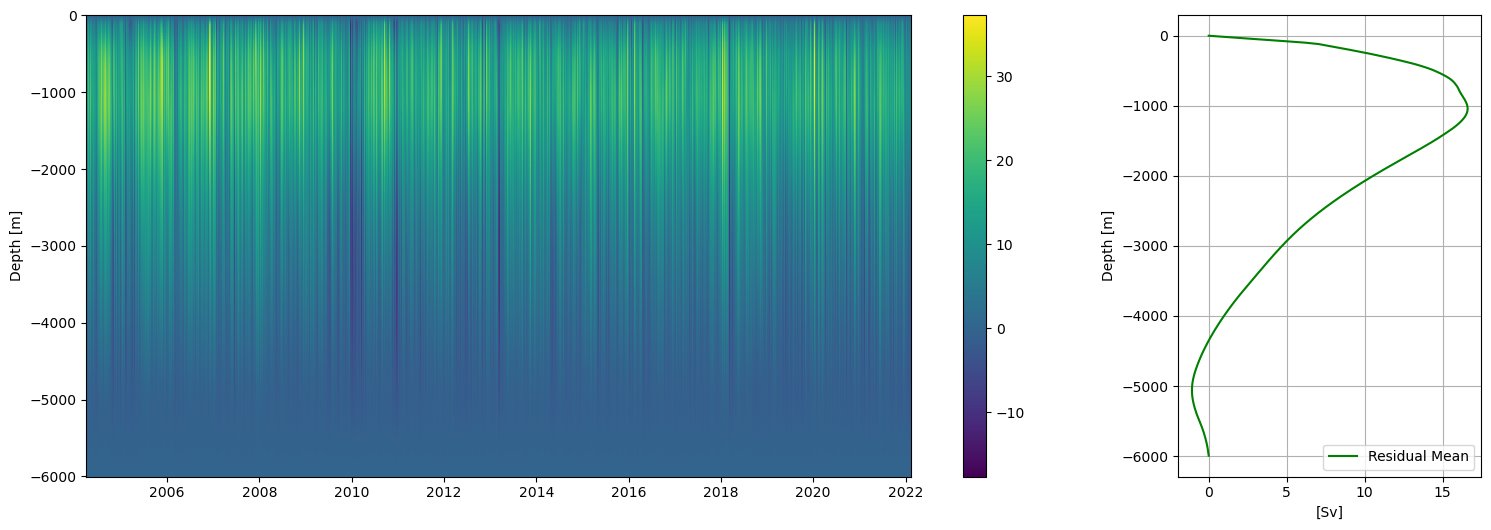

In [52]:
plot(PSI_RAPID, depth_param='k', transpose=False)

In [38]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import xarray as xr

PSI = yearly_averages

# Setup figure
fig, ax = plt.subplots(figsize=(4,4))
line, = ax.plot([], [], color='green', label='Residual Mean')
ax.set_xlim([PSI['psi_moc'].min(), PSI['psi_moc'].max()])  # Adjust x-axis limits
ax.set_ylim([PSI['k'].min()-2, PSI['k'].max()+2]) 
ax.set_ylabel("Depth [m]")
ax.set_xlabel("[Sv]")
ax.grid()
ax.legend()

# Initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

# Animation update function
def update(frame):
    y_data = PSI['psi_moc'].isel(time=frame)
    line.set_data(y_data, PSI["k"])
    return (line,)

# Create animation
ani = FuncAnimation(fig, update, frames=range(0, 313),
                    init_func=init, blit=True)

plt.show()

<IPython.core.display.Javascript object>

In [85]:
importlib.reload(cell_decomposition)

<module 'streamfunction_ecco.cell_decomposition' from 'C:\\Users\\aline\\OTP\\streamfunction_ecco\\cell_decomposition.py'>

In [104]:
str = ""
#psi_data = cell_decomposition.find_depths_of_interest(PSI_RAPID, depth_grid=PSI_RAPID["k"])
psi_data = cell_decomposition.find_depths_of_interest(PSI_26)

psi_data['dist_upper_cell'] = abs(psi_data["depth_max"]-psi_data["depth_zero"]).squeeze()
psi_data['dist_lower_cell'] = abs(psi_data["depth_min"]-psi_data["depth_zero"]).squeeze()

psi_ecco_resampled = psi_data.resample(time='6M').mean()

len 312


In [105]:
psi_data = cell_decomposition.find_depths_of_interest(PSI_RAPID, depth_grid=PSI_RAPID["k"])

psi_data['dist_upper_cell'] = abs(psi_data["depth_max"]-psi_data["depth_zero"]).squeeze()
psi_data['dist_lower_cell'] = abs(psi_data["depth_min"]-psi_data["depth_zero"]).squeeze()

psi_rapid_resampled = psi_data.resample(time='6M').mean()

len 13057


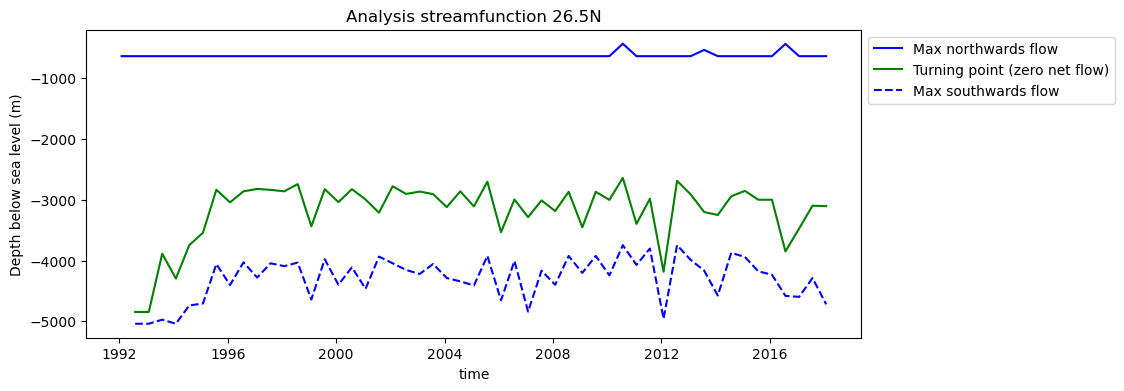

In [100]:
cell_decomposition.plot_3_cells(psi_rapid_resampled, '26.5N')

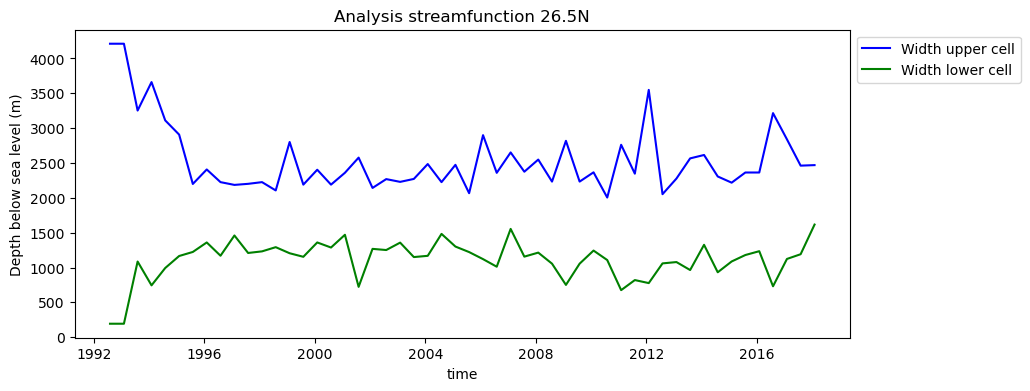

In [102]:
cell_decomposition.plot_distances(psi_rapid_resampled, '26.5N')

In [134]:
def plot_6_cells(psi_data, psi_rapid, latitude, str=""):
    plt.figure(figsize=(10, 4))

    plt.plot(
        psi_data["time"],
        psi_data[f"{str}depth_max"],
        color="green",
        linestyle='dashed',
        label="Ecco max northwards flow",
    )
    plt.plot(
        psi_data["time"],
        psi_data[f"{str}depth_zero"],
        color="green",
        label="Ecco turning point (zero net flow)",
    )
    plt.plot(
        psi_data["time"],
        psi_data[f"{str}depth_min"],
        color="green",
        linestyle="dotted",
        label="Ecco max southwards flow",
    )
    
    plt.plot(
        psi_rapid["time"],
        psi_rapid[f"{str}depth_max"],
        color="orange",
        linestyle='dashed',
        label="RAPID max northwards flow",
    )
    plt.plot(
        psi_rapid["time"],
        psi_rapid[f"{str}depth_zero"],
        color="orange",
        label="RAPID turning point (zero net flow)",
    )
    plt.plot(
        psi_rapid["time"],
        psi_rapid[f"{str}depth_min"],
        color="orange",
        linestyle="dotted",
        label="RAPID max southwards flow",
    )

    plt.xlim([datetime(2004, 1, 1), datetime(2018, 12, 30)])

    plt.title(f"Analysis streamfunction {latitude}")
    plt.xlabel("time")
    plt.ylabel("Depth below sea level (m)")
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

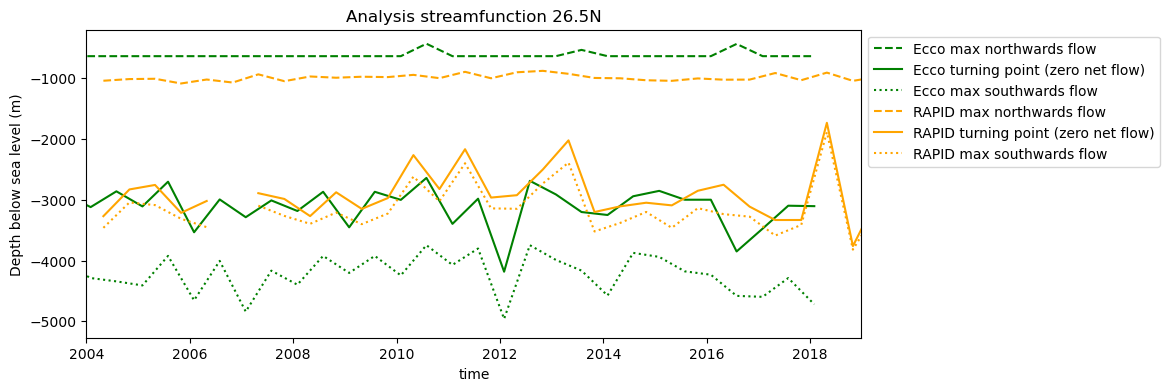

In [135]:
plot_6_cells(psi_ecco_resampled, psi_rapid_resampled, latitude='26.5N')

In [138]:
def plot_2_distances(psi_data, psi_rapid, latitude):
    plt.figure(figsize=(10, 4))

    plt.plot(
        psi_data["time"],
        psi_data["dist_upper_cell"],
        color="green",
        linestyle="dashed", 
        label="Ecco width upper cell",
    )
    plt.plot(
        psi_data["time"],
        psi_data["dist_lower_cell"],
        color="green",
        linestyle="dotted",
        label="Ecco width lower cell",
    )
    
    plt.plot(
        psi_rapid["time"],
        psi_rapid["dist_upper_cell"],
        color="orange",
        linestyle="dashed", 
        label="RAPID width upper cell",
    )
    plt.plot(
        psi_rapid["time"],
        psi_rapid["dist_lower_cell"],
        color="orange",
        linestyle="dotted",
        label="RAPID width lower cell",
    )

    plt.title(f"Analysis streamfunction {latitude}")
    plt.xlim([datetime(2004, 1, 1), datetime(2018, 12, 30)])
    plt.xlabel("time")
    plt.ylabel("Depth below sea level (m)")
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

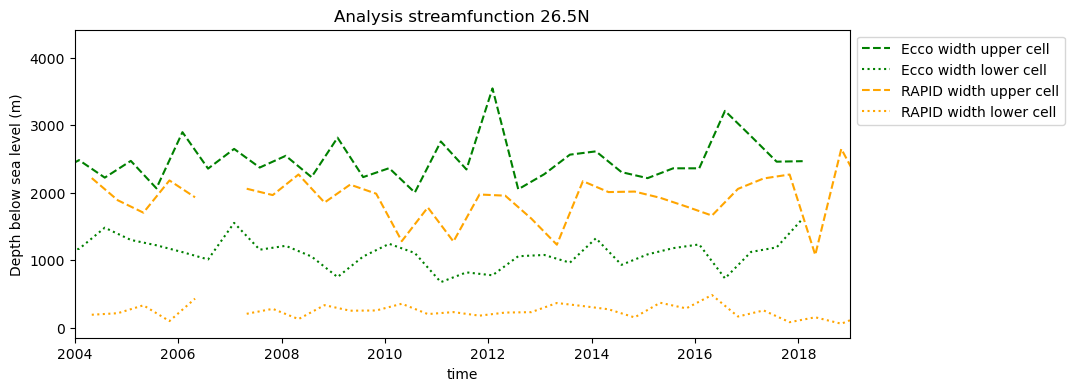

In [139]:
plot_2_distances(psi_ecco_resampled, psi_rapid_resampled, latitude="26.5N")